## Engenharia do Conhecimento 2023/2024

### Project: Classification and Regression models with *Thyroid disease Data Set*

#### Group 6:

- Eduardo Proença 57551
- Tiago Oliveira 54979
- Bernardo Lopes 54386

### 1. Data Processing

#### 1.1 Creating a Data Frame

In [267]:
import pandas as pd

df_thyroid = pd.read_csv('proj-data.csv')
df_thyroid.shape

(7338, 31)

#### 1.2 Data investigation

In [268]:
import numpy as np

df = df_thyroid.copy()
df.replace('?', np.nan, inplace=True)
df_cleaned = df.drop('[record identification]', axis = 1)
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7338 entries, 0 to 7337
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   age:                        7338 non-null   int64 
 1   sex:                        7098 non-null   object
 2   on thyroxine:               7338 non-null   object
 3   query on thyroxine:         7338 non-null   object
 4   on antithyroid medication:  7338 non-null   object
 5   sick:                       7338 non-null   object
 6   pregnant:                   7338 non-null   object
 7   thyroid surgery:            7338 non-null   object
 8   I131 treatment:             7338 non-null   object
 9   query hypothyroid:          7338 non-null   object
 10  query hyperthyroid:         7338 non-null   object
 11  lithium:                    7338 non-null   object
 12  goitre:                     7338 non-null   object
 13  tumor:                      7338 non-null   obje

#### 1.3 Encoding Data

In [269]:
def encode_df(df):
    encoded_values = {
        'M': '0', 'F': '1',
        'f': '0', 't': '1',
        'WEST': '0', 'STMW': '1',
        'SVHC': '2', 'SVI': '3',
        'SVHD': '4', 'other': '5'
    }
    df_data = df.drop('diagnoses', axis = 1)
    encoded = pd.DataFrame(df_data.replace(encoded_values), columns=df_data.columns)
    diagnoses_encoded = {
        '-': 0,                          # healthy
        'A': 1, 'B': 1, 'C': 1, 'D': 1,  # hyperthyroid conditions
        'E': 2, 'F': 2, 'G': 2, 'H': 2,  # hypothyroid conditions
        'I': 3, 'J': 3,                  # binding protein
        'K': 4,                          # general health
        'L': 5, 'M': 5, 'N': 5,          # replacement therapy
        'R': 6,                          # discordant results
    }
    diagnoses = pd.DataFrame(df['diagnoses'], columns=['diagnoses'])
    diagnoses['diagnoses'] = diagnoses['diagnoses'].map(diagnoses_encoded).fillna(7).astype(int)
    return pd.concat([encoded, diagnoses], axis=1)

df_encoded = encode_df(df_cleaned)
df_encoded.head()

,age:,sex:,on thyroxine:,query on thyroxine:,on antithyroid medication:,sick:,pregnant:,thyroid surgery:,I131 treatment:,query hypothyroid:,...,TT4 measured:,TT4:,T4U measured:,T4U:,FTI measured:,FTI:,TBG measured:,TBG:,referral source:,diagnoses
0,29,1,0,0,0,0,0,0,0,1,...,0,NaN,0,NaN,0,NaN,0,NaN,5,0
1,29,1,0,0,0,0,0,0,0,0,...,1,128,0,NaN,0,NaN,0,NaN,5,0
2,36,1,0,0,0,0,0,0,0,0,...,0,NaN,0,NaN,0,NaN,1,26,5,0
3,60,1,0,0,0,0,0,0,0,0,...,0,NaN,0,NaN,0,NaN,1,26,5,0
4,77,1,0,0,0,0,0,0,0,0,...,0,NaN,0,NaN,0,NaN,1,21,5,0


#### 1.4 Scaling Data

In [270]:
from sklearn.preprocessing import StandardScaler

def scale_data(X_train, X_test):
    scaler = StandardScaler()
    scaler.fit(X_train)
    return scaler.transform(X_train), scaler.transform(X_test)

#### 1.5 Imputing missing values

In [271]:
from sklearn.impute import SimpleImputer

def impute_data(X_train, X_test):
    imputer = SimpleImputer(strategy='mean')
    imputer.fit(X_train)
    return imputer.transform(X_train), imputer.transform(X_test)

### 2. Classification Models

In [272]:
from sklearn.model_selection import train_test_split

X = df_encoded.drop('diagnoses', axis='columns')
y = df_encoded['diagnoses']
X_TRAIN, X_TEST, y_TRAIN, y_TEST = train_test_split(X, y, test_size=0.2)
X_train_scl, X_test_scl = scale_data(X_TRAIN, X_TEST)
X_train_imp, X_test_imp = impute_data(X_train_scl, X_test_scl)

X_TRAIN = pd.DataFrame(X_train_imp, columns=X_TRAIN.columns)
X_TEST = pd.DataFrame(X_test_imp, columns=X_TEST.columns)

#### 2.1 Feature Selection

In [273]:
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LogisticRegression

def feature_selection(model, X_train, y_train, X_test, verbose=False): 
    selector = SFS(model, n_features_to_select=13, direction='forward', n_jobs=-1)
    selector.fit(X_train, y_train)
    if verbose:
        N, M = X_train.shape
        features_selected = np.arange(M)[selector.get_support()]
        print("The features selected are columns: ", features_selected)
    return selector.transform(X_train), selector.transform(X_test)

X_TRAIN, X_TEST = feature_selection(LogisticRegression(), X_TRAIN, y_TRAIN, X_TEST, True)

The features selected are columns:  [ 2  7 14 15 16 17 19 21 24 25 26 27 28]


#### 2.2 KFold Cross Validation

In [274]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

def cross_validation(model, X, y):
    TRUTH = None
    PREDS = None
    kf = KFold(n_splits=5, shuffle=True)
    for train_index, test_index in kf.split(X):
        X_train, y_train = X[train_index], y.to_numpy()[train_index]
        X_test, y_test = X[test_index], y.to_numpy()[test_index]
        
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        if TRUTH is None:
            PREDS = preds
            TRUTH = y_test
        else:
            PREDS = np.hstack((PREDS, preds))
            TRUTH = np.hstack((TRUTH, y_test))
    return TRUTH, PREDS

In [275]:
def evaluate(model, X, y, n_iter=10):
    acc, pre, rec, f1, mcc = [], [], [], [], []
    for _ in range(n_iter):
        truth, preds = cross_validation(model, X, y)
        acc.append(accuracy_score(truth, preds))
        pre.append(precision_score(truth, preds, average='weighted', zero_division=1))
        rec.append(recall_score(truth, preds, average='weighted'))
        f1.append(f1_score(truth, preds, average='weighted'))
        mcc.append(matthews_corrcoef(truth, preds)) 
    return {
        'Model': model,
        'Accuracy': np.mean(acc),
        'Precision': np.mean(pre),
        'Recall': np.mean(rec),
        'F1-Score': np.mean(f1),
        'MCC': np.mean(mcc)
    }

#### 2.3 Model Evaluation

In [276]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

eval_metrics = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'MCC']
tree = evaluate(DecisionTreeClassifier(), X_TRAIN, y_TRAIN)
lgr = evaluate(LogisticRegression(), X_TRAIN, y_TRAIN)
naive_bayes = evaluate(GaussianNB(), X_TRAIN, y_TRAIN)
knn = evaluate(KNeighborsClassifier(), X_TRAIN, y_TRAIN)
svm = evaluate(SVC(), X_TRAIN, y_TRAIN)
pd.DataFrame([tree, lgr, naive_bayes, knn, svm], columns=eval_metrics)

,Model,Accuracy,Precision,Recall,F1-Score,MCC
0,DecisionTreeClassifier(),0.923850,0.923427,0.923850,0.923564,0.827400
1,LogisticRegression(),0.848620,0.834361,0.848620,0.828686,0.616758
2,GaussianNB(),0.131175,0.763426,0.131175,0.134283,0.162789
3,KNeighborsClassifier(),0.864855,0.856764,0.864855,0.852288,0.664816
4,SVC(),0.843458,0.835597,0.843458,0.816916,0.598402


#### 2.4 Hyperparameter Tuning

In [277]:
model_params = {
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'max_depth': [2, 3, 5, 10, 20],
            'min_samples_split': [2, 3, 5, 10, 15],
            'min_samples_leaf': [2, 3, 5, 10, 15],
            'criterion': ['gini', 'entropy', 'log_loss']
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors' : [3, 5, 7, 9, 11],
            'weights' : ['uniform', 'distance'],
            'metric' : ['minkowski', 'euclidean', 'manhattan']
        }
    },
    'SVC': {
        'model': SVC(),
        'params': {
            'C': [0.1, 1, 10, 100],  
            'gamma': [1, 0.1, 0.01, 0.001], 
            'kernel': ['rbf', 'linear'] 
        }
    }
}

In [278]:
from sklearn.model_selection import GridSearchCV

scores = []
for name, model in model_params.items():
    grid_search = GridSearchCV(model['model'], model['params'], cv=5, n_jobs=-1)
    grid_search.fit(X_TRAIN, y_TRAIN)
    scores.append({
        'Best Estimator': grid_search.best_estimator_,
        'Best Score': grid_search.best_score_,
        'Best Params': grid_search.best_params_
    })
df_tuning = pd.DataFrame(scores, columns=['Best Estimator', 'Best Score', 'Best Params'])
df_tuning

,Best Estimator,Best Score,Best Params
0,"DecisionTreeClassifier(criterion='entropy', ma...",0.933731,"{'criterion': 'entropy', 'max_depth': 20, 'min..."
1,"KNeighborsClassifier(n_neighbors=7, weights='d...",0.872232,"{'metric': 'minkowski', 'n_neighbors': 7, 'wei..."
2,"SVC(C=100, gamma=0.1)",0.896082,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}"


#### 2.5 Model Selection

In [279]:
best_classification_model = df_tuning.at[df_tuning['Best Score'].idxmax(), 'Best Estimator']
print("-------------- Best Classification Model: -------------- \n")
print(best_classification_model)

-------------- Best Classification Model: -------------- 

DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_leaf=3,
                       min_samples_split=10)


In [280]:
evaluation = pd.DataFrame([evaluate(best_classification_model, X_TRAIN, y_TRAIN)], columns=eval_metrics)
evaluation

,Model,Accuracy,Precision,Recall,F1-Score,MCC
0,"DecisionTreeClassifier(criterion='entropy', ma...",0.930903,0.929699,0.930903,0.930167,0.842398


#### 2.6 Model Testing

In [281]:
best_classification_model.fit(X_TRAIN, y_TRAIN)
preds = best_classification_model.predict(X_TEST)
test_report = {
    'Model': best_classification_model,
    'Accuracy': accuracy_score(y_TEST, preds),
    'Precision': precision_score(y_TEST, preds, average='weighted', zero_division=1),
    'Recall': recall_score(y_TEST, preds, average='weighted'),
    'F1-Score': f1_score(y_TEST, preds, average='weighted'),
    'MCC': matthews_corrcoef(y_TEST, preds)
}
best_model_test = pd.DataFrame([test_report], columns=eval_metrics)
best_model_test

,Model,Accuracy,Precision,Recall,F1-Score,MCC
0,"DecisionTreeClassifier(criterion='entropy', ma...",0.939373,0.938153,0.939373,0.938238,0.860254


### 3. Predicting age

RMSE:  30.36897732352621


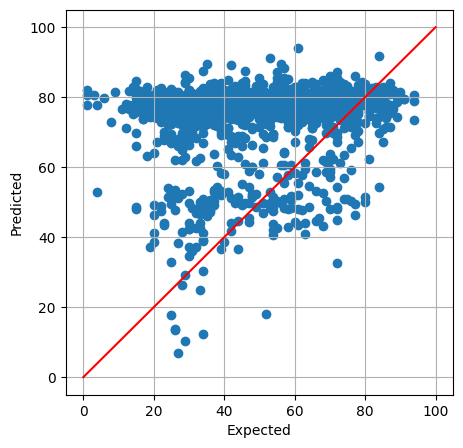

In [285]:
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
from sklearn.metrics import root_mean_squared_error

X = df_encoded.drop('age:', axis='columns')
y = df_encoded['age:']
X_TRAIN, X_TEST, y_TRAIN, y_TEST = train_test_split(X, y, test_size=0.2)
X_train_scl, X_test_scl = scale_data(X_TRAIN, X_TEST)
X_train_imp, X_test_imp = impute_data(X_train_scl, X_test_scl)
X_TRAIN = pd.DataFrame(X_train_imp, columns=X_TRAIN.columns)
X_TEST = pd.DataFrame(X_test_imp, columns=X_TEST.columns)

X_TRAIN, X_TEST = feature_selection(LinearRegression(), X_TRAIN, y_TRAIN, X_TEST)
model = LinearRegression()
model.fit(X_TRAIN, y_TRAIN)
preds = model.predict(X_TEST)

print("RMSE: ", root_mean_squared_error(y_TEST, preds))
plt.figure(figsize=(5,5))
plt.scatter(y_TEST, preds)
plt.plot((0,100), (0,100), c="r")
plt.xlabel("Expected")
plt.ylabel("Predicted")
plt.grid()
plt.show()

### 4. Predicting sex

In [283]:
df_sex = df_encoded.dropna(subset=['sex:'])
X = df_sex.drop('sex:', axis='columns')
y = df_sex['sex:']
X_TRAIN, X_TEST, y_TRAIN, y_TEST = train_test_split(X, y, test_size=0.2)
X_train_scl, X_test_scl = scale_data(X_TRAIN, X_TEST)
X_train_imp, X_test_imp = impute_data(X_train_scl, X_test_scl)
X_TRAIN = pd.DataFrame(X_train_imp, columns=X_TRAIN.columns)
X_TEST = pd.DataFrame(X_test_imp, columns=X_TEST.columns)

X_TRAIN, X_TEST = feature_selection(LogisticRegression(), X_TRAIN, y_TRAIN, X_TEST)
tree = evaluate(DecisionTreeClassifier(), X_TRAIN, y_TRAIN)
lgr = evaluate(LogisticRegression(), X_TRAIN, y_TRAIN)
naive_bayes = evaluate(GaussianNB(), X_TRAIN, y_TRAIN)
knn = evaluate(KNeighborsClassifier(), X_TRAIN, y_TRAIN)
svm = evaluate(SVC(), X_TRAIN, y_TRAIN)
pd.DataFrame([tree, lgr, naive_bayes, knn, svm], columns=eval_metrics)

,Model,Accuracy,Precision,Recall,F1-Score,MCC
0,DecisionTreeClassifier(),0.594664,0.610154,0.594664,0.601241,0.099201
1,LogisticRegression(),0.694628,0.663482,0.694628,0.625150,0.161200
2,GaussianNB(),0.413649,0.603310,0.413649,0.382911,0.048059
3,KNeighborsClassifier(),0.656023,0.631800,0.656023,0.638989,0.146163
4,SVC(),0.686474,0.644751,0.686474,0.593185,0.101645


Run this cell to test our models with the test data set (This cell is only for testing purposes)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
from sklearn.tree import DecisionTreeClassifier

eval_metrics = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'MCC']

def encode_df(df):
    encoded_values = {
        'M': '0', 'F': '1',
        'f': '0', 't': '1',
        'WEST': '0', 'STMW': '1',
        'SVHC': '2', 'SVI': '3',
        'SVHD': '4', 'other': '5'
    }
    df_data = df.drop('diagnoses', axis = 1)
    encoded = pd.DataFrame(df_data.replace(encoded_values), columns=df_data.columns)
    diagnoses_encoded = {
        '-': 0,                          # healthy
        'A': 1, 'B': 1, 'C': 1, 'D': 1,  # hyperthyroid conditions
        'E': 2, 'F': 2, 'G': 2, 'H': 2,  # hypothyroid conditions
        'I': 3, 'J': 3,                  # binding protein
        'K': 4,                          # general health
        'L': 5, 'M': 5, 'N': 5,          # replacement therapy
        'R': 6,                          # discordant results
    }
    diagnoses = pd.DataFrame(df['diagnoses'], columns=['diagnoses'])
    diagnoses['diagnoses'] = diagnoses['diagnoses'].map(diagnoses_encoded).fillna(7).astype(int)
    return pd.concat([encoded, diagnoses], axis=1)

def scale_data(X_train, X_test):
    scaler = StandardScaler()
    scaler.fit(X_train)
    return scaler.transform(X_train), scaler.transform(X_test)

def impute_data(X_train, X_test):
    imputer = SimpleImputer(strategy='mean')
    imputer.fit(X_train)
    return imputer.transform(X_train), imputer.transform(X_test)

def feature_selection(X_train, y_train, X_test, verbose=False): 
    selector = SFS(LogisticRegression(), n_features_to_select=13, direction='forward', n_jobs=-1)
    selector.fit(X_train, y_train)
    if verbose:
        N, M = X_train.shape
        features=selector.get_support()
        features_selected = np.arange(M)[features]
        print("The features selected are columns: ", features_selected)
    return selector.transform(X_train), selector.transform(X_test)

df_copy = pd.read_csv('proj-data.csv')
df_X_IVS = pd.read_csv('proj-test-data.csv') # Replace with the complete IVS set !
df_y_IVS = pd.read_csv('proj-test-class.csv') # Replace with the complete IVS set !
df_IVS = pd.concat([df_X_IVS, df_y_IVS], axis=1)

df_copy.replace('?', np.nan, inplace=True)
df_IVS.replace('?', np.nan, inplace=True)
df_clean = df_copy.drop('[record identification]', axis = 1)
df_IVS_clean = df_IVS.drop('[record identification]', axis = 1)
test_encoded = encode_df(df_clean)
df_IVS_encoded = encode_df(df_IVS_clean)

X = test_encoded.drop('diagnoses', axis = 1)
y = test_encoded['diagnoses']
X_IVS = df_IVS_encoded.drop('diagnoses', axis = 1)
y_IVS = df_IVS_encoded['diagnoses']
X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2)

X_train_scl, X_ivs_scl = scale_data(X_train, X_IVS)
X_train_imp, X_ivs_imp = impute_data(X_train_scl, X_ivs_scl)
X_train_processed = pd.DataFrame(X_train_imp, columns=X_train.columns)
X_ivs_processed = pd.DataFrame(X_ivs_imp, columns=X_IVS.columns)
X_train, X_IVS = feature_selection(X_train_processed, y_train, X_ivs_processed)

##### Define the best classification model here ######
classification_model = DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_leaf=3, min_samples_split=10)
classification_model.fit(X_train, y_train)
preds = classification_model.predict(X_IVS)
results = {
    'Model': classification_model,
    'Accuracy': accuracy_score(y_IVS, preds),
    'Precision': precision_score(y_IVS, preds, average='weighted', zero_division=1),
    'Recall': recall_score(y_IVS, preds, average='weighted'),
    'F1-Score': f1_score(y_IVS, preds, average='weighted'),
    'MCC': matthews_corrcoef(y_IVS, preds)
}
########### Remove comment to show results ############
# ivs_testing = pd.DataFrame([results], columns=eval_metrics)
# ivs_testing